## Conformer Search

The goal in Conformer optimization is to find the most stable 3D structure of a molecule 
which differ by dihedral angles, bond angles and bond lengths.
We use tensor trains to avoid the exponential complexity of the
conformer search problem.

A more detailed explanation can be found in our [paper](http://dx.doi.org/10.26434/chemrxiv-2024-jjns1).

### Representation of a molecule

The internal representation of a molecule in TQchem is the MolecularSystem class,
which can be initialized from a variety of popular molecule representations.
TQchem supports conversion from:
- rdkit.Mol
- ase.Atoms
- smiles string
- xyz file/xyz block

For example, below is an example of creating a MolecularSystem object from an xyz block:

In [1]:
from tqchem.viewer import plot_3D_molecule
from tqchem.molgraph import molecularSystem

xyz_block = """13

C     -1.044461   -0.825824    0.211330
C     -0.285778    0.490479    0.068986
O     -0.589226    1.155464   -1.136284
C      1.232755    0.259051    0.185495
O      1.610069   -0.323671    1.406869
H     -2.115750   -0.643571    0.208448
H     -0.791736   -1.487830   -0.614662
H     -0.764530   -1.309872    1.143418
H     -0.605130    1.182551    0.857893
H     -0.296714    0.606873   -1.873951
H      1.557840   -0.441551   -0.590202
H      1.752598    1.214578    0.025047
H      1.331217    0.249819    2.128887"""

initial_molecule = molecularSystem(xyz_block)
plot_3D_molecule(initial_molecule.ase).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Perform optimization

Here we run `ttconf` with 2 sweeps and rank 2 for the xyz representation of propylene glycol.

This could also be done from the command line using:
```bash
tqchem ttconf --xyz propyleneglycol.xyz --rank 2 --n_sweeps 2
```
Or for the smiles string:
```bash
tqchem ttconf CC(CO)O --rank 2 --n_sweeps 2
```

In [2]:
from tqchem.ttconf.factory import ttconf_optimizer

ttopt = ttconf_optimizer(initial_molecule, filter_type="energy")

results = ttopt.optimize()
best_conformer_xyz, energy_best_conformer = results.minimum_energy_xyz()
best_conformer = molecularSystem(best_conformer_xyz)

print(f"{energy_best_conformer = }")


      sweep | index |   Objective  | Runtime
     -----------------------------------------------
          1 |     3 |  -506.703733 | 0:00:01.447695
          1 |     2 |  -506.736523 | 0:00:03.526279
          1 |     1 |  -506.739942 | 0:00:04.336713
          2 |     1 |  -506.739942 | 0:00:04.337227
          2 |     2 |  -506.739942 | 0:00:07.245324
          2 |     3 |  -506.739942 | 0:00:08.255990
energy_best_conformer = -506.7399424741814


### Visualize the molecule with lowest energy

In [3]:
plot_3D_molecule(best_conformer_xyz).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Optimize structure using CREST:

Although global optimization in TTConf includes local optimization, 
it is often useful to perform a "final" local optimization of the structure at the end of the global optimization. 
Below we perform the optimization of a conformational ensemble with an energy window of 6 kcal/mol from the minimal conformer
using the [CREST](https://crest-lab.github.io/crest-docs/) wrapper built into TQchem:

In [4]:
from tqchem.chem import ase_from_molecule_file_content
from tqchem.ttconf.crest_wrapper import launch_crest
import numpy as np

xyzs = results.minimum_energy_ensemble(
    energy_difference=0.26,
    rmsd_cutoff=0.125,
)
ensemble = [ase_from_molecule_file_content(xyz) for xyz in xyzs]
optimized_ensemble, optimized_energies = launch_crest(
    ensemble,
    optlevel="normal",
)

best_conformer_crestOpt = np.argmin(optimized_energies)
energy_best_conformer_crestOpt = optimized_energies[best_conformer_crestOpt]
molecule_best_conformer_crestOpt = optimized_ensemble[best_conformer_crestOpt]

### Compare energies of rdkit and ttconf conformers

In [5]:
from tblite.ase import TBLite

# Energy of initial rdkit conformer
initial_molecule.ase.calc = TBLite(method="GFN2-xTB", verbosity=0)
energy_initial = initial_molecule.ase.get_potential_energy()

# Energy of the TTconf optimized, but not gradient optimized molecule
best_conformer.ase.calc = TBLite(method="GFN2-xTB", verbosity=0)
energy_best_conformer = best_conformer.ase.get_potential_energy()

energies = {
    "E(initial geometry)     ": energy_initial,
    "E(TTconf geometry)      ": energy_best_conformer,
    "E(TTconf+CREST geometry)": energy_best_conformer_crestOpt,
}
print("\n".join(f"{label}: {e:.7f}" for label, e in energies.items()))

E(initial geometry)     : -506.7007039
E(TTconf geometry)      : -506.7399425
E(TTconf+CREST geometry): -506.7423777


In [6]:
print("TTconf best geometry:")
plot_3D_molecule(molecule_best_conformer_crestOpt).show()

TTconf best geometry:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Bond selection

It is possible to select the bonds that are considered rotatable.
For the bond selection we first investigate the molecular graph and then select the bonds (as tuple of 2 atom IDs) 
and corresponding dihedral values (as array).

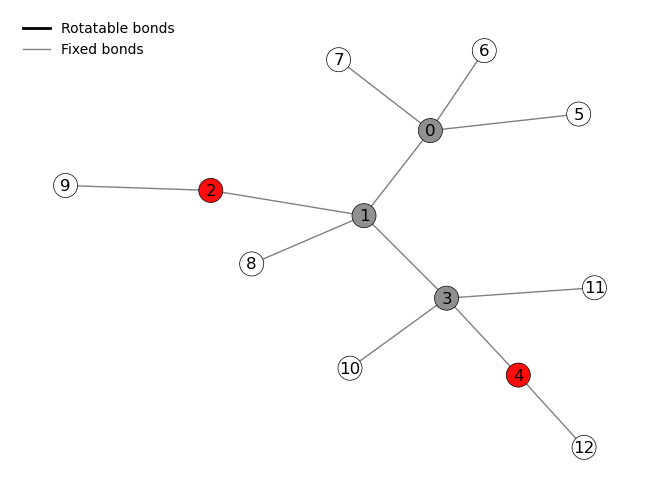

In [7]:
import numpy as np

xyz_block = """13

C     -1.044461   -0.825824    0.211330
C     -0.285778    0.490479    0.068986
O     -0.589226    1.155464   -1.136284
C      1.232755    0.259051    0.185495
O      1.610069   -0.323671    1.406869
H     -2.115750   -0.643571    0.208448
H     -0.791736   -1.487830   -0.614662
H     -0.764530   -1.309872    1.143418
H     -0.605130    1.182551    0.857893
H     -0.296714    0.606873   -1.873951
H      1.557840   -0.441551   -0.590202
H      1.752598    1.214578    0.025047
H      1.331217    0.249819    2.128887"""

initial_molecule = molecularSystem(xyz_block)
initial_molecule.draw()

In [8]:
ttopt = ttconf_optimizer(
    initial_molecule,
    charge=0,
    solvent=None,
    method="GFN2-xTB",
    ensemble_optimization=True,
    set_rotatable_bonds={(0, 1): np.linspace(0, 360, 12, endpoint=False)},
)

results = ttopt.optimize()
one_dihedral_xyz, energy_one_dihedral = results.minimum_energy_xyz()
one_dihedral = molecularSystem(one_dihedral_xyz)
print(f"{energy_one_dihedral = }")
plot_3D_molecule(one_dihedral_xyz).show()


      sweep | index |   Objective  | Runtime
     -----------------------------------------------
          1 |     1 |  -506.704737 | 0:00:00.572068
          2 |     1 |  -506.704737 | 0:00:00.572455
energy_one_dihedral = -506.7047367387411


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Ring systems
At the moment, only 5- and 6-rings can be optimized with TTconf as we implemented a different way of treating rings.


In [9]:
from tqchem.viewer import plot_3D_molecule

initial_molecule = molecularSystem("O1CCCCC1CCO")
plot_3D_molecule(initial_molecule.ase).show()

ttopt = ttconf_optimizer(
    initial_molecule,
    filter_type="energy",
    charge=0,
    solvent=None,
    method="GFN2-xTB",
    ensemble_optimization=True,
)

results = ttopt.optimize()
best_conformer_xyz, energy_best_conformer = results.minimum_energy_xyz()
best_conformer = molecularSystem(best_conformer_xyz)

print(f"{energy_best_conformer = }")
plot_3D_molecule(best_conformer_xyz).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.


      sweep | index |   Objective  | Runtime
     -----------------------------------------------
          1 |     4 |  -823.571253 | 0:00:02.276078
          1 |     3 |  -823.597379 | 0:00:06.952778
          1 |     2 |  -823.598813 | 0:00:10.225388
          1 |     1 |  -823.649913 | 0:00:11.172686
          2 |     1 |  -823.649913 | 0:00:11.173265
          2 |     2 |  -823.649955 | 0:00:12.806396
          2 |     3 |  -823.749278 | 0:00:16.092978
          2 |     4 |  -823.749278 | 0:00:17.347438
energy_best_conformer = -823.7492781160647


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

For bigger rings like a 7-ring the optimization with default parameters will fail.

In [10]:
initial_molecule = molecularSystem("O1CCC(CCN)CCC1")
plot_3D_molecule(initial_molecule.ase).show()

try:
    ttopt = ttconf_optimizer(initial_molecule)
except Exception:
    print("Impossible to run calculations for 7-ring with default settings.")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Impossible to run calculations for 7-ring with default settings.


It is, however, possible to avoid the separate treatment of rings by setting `single_batframe=True`

In [11]:
initial_molecule = molecularSystem("O1CCC(CCN)CCC1", single_batframe=True)

ttopt = ttconf_optimizer(
    initial_molecule,
    charge=0,
    filter_type="boltzmann energy difference",
    solvent=None,
    method="GFN2-xTB",
    ensemble_optimization=True,
)

results = ttopt.optimize()
best_conformer_xyz, energy_best_conformer = results.minimum_energy_xyz()
best_conformer = molecularSystem(best_conformer_xyz)

print(f"{energy_best_conformer = }")
plot_3D_molecule(initial_molecule.ase).show()


      sweep | index |   Objective  | Runtime
     -----------------------------------------------
          1 |     3 |    -8.432938 | 0:00:01.895418
          1 |     2 |   -14.969960 | 0:00:04.820821
          1 |     1 |   -16.708092 | 0:00:06.691786
          2 |     1 |   -16.708092 | 0:00:06.692577
          2 |     2 |   -16.716360 | 0:00:08.269578
          2 |     3 |   -19.317325 | 0:00:09.802838
energy_best_conformer = -892.0589298575549


3Dmol.js failed to load for some reason. Please check your browser console for error messages.